In [1]:
import pandas as pd
import re
import yaml
import sqlparse
import os
import pandas as pd
import requests
from IPython.display import display, Markdown


In [2]:
def add_repo_root_path():
    import os
    import sys
    repo_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
    if repo_root not in sys.path:
        sys.path.append(repo_root)
        
add_repo_root_path()
from src import generate_knowledge

In [3]:
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 50)
#pd.set_option('display.width', None)
#pd.set_option('display.max_colwidth', 10) 

## Read dbs

In [4]:
local_dbt_repo = ''
online_dbt_repo = 'https://github.com/dbt-labs/jaffle-shop'

# Use local repo?
if False:
    repo_path = local_dbt_repo
else:
    repo_path = online_dbt_repo

is_online = generate_knowledge.is_online_repo(repo_path)
_, repo_name = generate_knowledge.extract_owner_and_repo(repo_path)
print(repo_name)

jaffle-shop


In [5]:
dbt_models_df = pd.read_csv('../data/dbt_models_' + repo_name + '.csv')
dbt_project_df = pd.read_csv('../data/dbt_project_' + repo_name + '.csv')
display(dbt_models_df.sample(3))
display(dbt_project_df.sample(3))

,path,name,extension,sql_code,config,materialized,is_snapshot,has_jinja_code,model_category,vertical,yml_code,tests,has_tests,sql_ids,has_select_all_in_last_select,has_group_by,primary_key,filters,is_filtered,macros,has_macros,parent_models,is_source_model,source,children_models,is_end_model,model_description,jinja_description
4,models/staging/stg_products.sql,stg_products.sql,.sql,WITH SOURCE AS\n (SELECT *\n FROM {{ source...,NaN,NaN,False,False,stg,products,"{'models': [{'name': 'stg_products', 'descript...","{'columns': {'product_id': ['not_null', 'uniqu...",True,['product_id'],True,False,product_id,NaN,False,['cents_to_dollars'],True,[],True,['ecom.raw_products'],"['order_items', 'products']",False,Retrieves product data from the 'raw_products'...,NaN
5,models/staging/stg_supplies.sql,stg_supplies.sql,.sql,WITH SOURCE AS\n (SELECT *\n FROM {{ source...,NaN,NaN,False,False,stg,supplies,"{'models': [{'name': 'stg_supplies', 'descript...","{'columns': {'supply_uuid': ['not_null', 'uniq...",True,"['product_id', 'supply_id']",True,False,supply_uuid,NaN,False,"['cents_to_dollars', 'dbt_utils.generate_surro...",True,[],True,['ecom.raw_supplies'],"['order_items', 'supplies']",False,Retrieves supply expense data from the 'raw_su...,NaN
10,models/marts/orders.sql,orders.sql,.sql,WITH orders AS\n (SELECT *\n FROM {{ ref('s...,NaN,NaN,False,False,other,orders,"{'models': [{'name': 'orders', 'description': ...","{'columns': {'order_id': ['not_null', 'unique'...",True,"['order_item_id', 'customer_id', 'order_id']",True,True,order_id,['orders.order_id = order_items_summary.order_...,True,NaN,False,"['stg_orders', 'order_items']",False,NaN,['customers'],False,"""Aggregates order data from the 'stg_orders' a...",NaN


,path,name,extension,code,is_seed,is_macro,is_test,packages,description
8,jaffle-data/raw_orders.csv,raw_orders.csv,.csv,id ...,False,False,False,NaN,NaN
6,jaffle-data/raw_customers.csv,raw_customers.csv,.csv,id ...,False,False,False,NaN,NaN
7,jaffle-data/raw_items.csv,raw_items.csv,.csv,id ...,False,False,False,NaN,NaN


In [6]:
def merge_dbt_models_and_project_dfs(dbt_models_df, dbt_project_df):
    dbt_models_df['knowledge_type'] = 'models'
    dbt_project_df['knowledge_type'] = 'project'

    dbt_models_df.rename(columns = {'sql_code':'code'}, inplace = True)

    all_columns = set(dbt_models_df.columns).union(set(dbt_project_df.columns))

    for col in all_columns:
        if col not in dbt_models_df:
            dbt_models_df[col] = None
        if col not in dbt_project_df:
            dbt_project_df[col] = None

    merged_df = pd.concat([dbt_models_df, dbt_project_df], ignore_index=True)
    columns_order = ['knowledge_type'] + [col for col in merged_df.columns if col != 'knowledge_type']
    return merged_df[columns_order]

In [7]:
dbt_repo_knowledge_df = merge_dbt_models_and_project_dfs(dbt_models_df, dbt_project_df)

## LangChain

#### Embeddings and Documents db

In [8]:
def combine_contextual_fields(row):
    combined = f"""        
        Code:
        {row['code'] if pd.notna(row['code']) else 'N/A'}

        Primary Key:
        {row['primary_key'] if pd.notna(row['primary_key']) else 'N/A'}

        IDS:
        {row['sql_ids'] if pd.notna(row['sql_ids']) else 'N/A'}

        Columns used to Filter the model throuhg JOINS, HAVING, WHERE...:
        {row['filters'] if pd.notna(row['filters']) else 'N/A'}

        Tests:
        {row['tests'] if pd.notna(row['tests']) else 'N/A'}

        YML Code:
        {row['yml_code'] if pd.notna(row['yml_code']) else 'N/A'}

        Description for project files:
        {row['description'] if pd.notna(row['description']) else 'N/A'}

        dbt Model description:
        {row['model_description'] if pd.notna(row['model_description']) else 'N/A'}

        Jinja inside the dbt model description:
        {row['jinja_description'] if pd.notna(row['jinja_description']) else 'N/A'}
    """
    return combined.strip()

dbt_repo_knowledge_df['contextual_info'] = dbt_repo_knowledge_df.apply(combine_contextual_fields, axis=1)

In [9]:
generate_knowledge.add_repo_root_path()
import openai_setup

OPENAI_API_KEY = openai_setup.conf['key']
OPENAI_PROJECT = openai_setup.conf['project']
OPENAI_ORGANIZATION = openai_setup.conf['organization']
DEFAULT_LLM_MODEL = "gpt-4o-mini"

In [10]:
from langchain.schema import Document

documents = dbt_repo_knowledge_df.apply(
    lambda row: Document(
        page_content=row["contextual_info"],
        metadata={
            "knowledge_type": row["knowledge_type"],
            "name": row["name"],
            "path": row["path"],
            "source": row["source"],
            "parents": row["parent_models"],
            "children": row["children_models"],
            "config": row["config"],
            "materialized": row["materialized"],
            "is_snapshot": row["is_snapshot"],
            "model_category": row["model_category"],
            "vertical": row["vertical"],
            "has_tests": row["has_tests"],
            "has_select_all_in_last_select": row["has_select_all_in_last_select"],
            "has_group_by": row["has_group_by"],
            "is_filtered": row["is_filtered"],
            "is_source_model": row["is_source_model"],
            "is_seed": row["is_seed"],
            "is_end_model": row["is_end_model"],
            "is_macro": row["is_macro"],
            "is_test": row["is_test"],
            "macros": row["macros"],
            "packages": row["packages"]
        }
    ), axis=1
).tolist()

In [11]:
display(dbt_repo_knowledge_df.sample(3))

,knowledge_type,path,name,extension,code,config,materialized,is_snapshot,has_jinja_code,model_category,vertical,yml_code,tests,has_tests,sql_ids,has_select_all_in_last_select,has_group_by,primary_key,filters,is_filtered,macros,has_macros,parent_models,is_source_model,source,children_models,is_end_model,model_description,jinja_description,description,is_seed,is_test,packages,is_macro,contextual_info
0,models,models/staging/stg_customers.sql,stg_customers.sql,.sql,WITH SOURCE AS\n (SELECT *\n FROM {{ source...,NaN,NaN,False,False,stg,customers,"{'models': [{'name': 'stg_customers', 'descrip...","{'columns': {'customer_id': ['not_null', 'uniq...",True,['customer_id'],True,False,customer_id,NaN,False,NaN,False,[],True,['ecom.raw_customers'],['customers'],False,"""Extracts customer data from the 'raw_customer...",NaN,None,None,None,None,None,Code:\n WITH SOURCE AS\n (SELECT *\n ...
7,models,models/marts/locations.sql,locations.sql,.sql,WITH locations AS\n (SELECT *\n FROM {{ ref...,NaN,NaN,False,False,other,locations,"{'semantic_models': [{'name': 'locations', 'de...",NaN,False,NaN,True,False,NaN,NaN,False,NaN,False,['stg_locations'],False,NaN,[],True,Retrieves all location records from the 'stg_l...,NaN,None,None,None,None,None,Code:\n WITH locations AS\n (SELECT *\...
5,models,models/staging/stg_supplies.sql,stg_supplies.sql,.sql,WITH SOURCE AS\n (SELECT *\n FROM {{ source...,NaN,NaN,False,False,stg,supplies,"{'models': [{'name': 'stg_supplies', 'descript...","{'columns': {'supply_uuid': ['not_null', 'uniq...",True,"['product_id', 'supply_id']",True,False,supply_uuid,NaN,False,"['cents_to_dollars', 'dbt_utils.generate_surro...",True,[],True,['ecom.raw_supplies'],"['order_items', 'supplies']",False,Retrieves supply expense data from the 'raw_su...,NaN,None,None,None,None,None,Code:\n WITH SOURCE AS\n (SELECT *\n ...


In [12]:
from langchain_openai import OpenAIEmbeddings
from langchain.vectorstores import FAISS

embeddings = OpenAIEmbeddings(openai_api_key=OPENAI_API_KEY)
vectorstore = FAISS.from_documents(documents, embeddings)
print(vectorstore)

#### Generate Lineage

In [13]:
import networkx as nx
import matplotlib.pyplot as plt

def plot_dbt_lineage(dbt_repo_knowledge_df):
    # Generate lineage df
    lineage_df = dbt_repo_knowledge_df[(dbt_repo_knowledge_df['knowledge_type'] == 'models') & (dbt_repo_knowledge_df['extension'] == '.sql')][['name','parent_models','children_models','source']]
    lineage_df['model_name'] = lineage_df['name'].apply(lambda x: x[:-4])
    lineage_df = lineage_df.drop(columns=['name'])[['model_name','source','parent_models','children_models']]

    # Ensure valid lists in columns
    lineage_df["source"] = lineage_df["source"].apply(lambda x: x if isinstance(x, list) else eval(x) if isinstance(x, str) and x.startswith('[') else [])
    lineage_df["parent_models"] = lineage_df["parent_models"].apply(lambda x: x if isinstance(x, list) else eval(x) if isinstance(x, str) and x.startswith('[') else [])
    lineage_df["children_models"] = lineage_df["children_models"].apply(lambda x: x if isinstance(x, list) else eval(x) if isinstance(x, str) and x.startswith('[') else [])

    # Create directed graph
    G = nx.DiGraph()

    # Add source nodes
    all_sources = lineage_df["source"].sum()
    unique_sources = list(set(all_sources))
    G.add_nodes_from(unique_sources, layer=0)

    # Add nodes and edges for models
    for _, row in lineage_df.iterrows():
        layer = 1 if row["source"] and not row["parent_models"] else 2 if row["source"] and row["parent_models"] else 3 if not row["source"] and row["parent_models"] and row["children_models"] else 4 if not row["children_models"] and row["parent_models"] else None
        if layer:
            G.add_node(row["model_name"], layer=layer)
            for source in row["source"]:
                G.add_edge(source, row["model_name"])
            for parent in row["parent_models"]:
                G.add_edge(parent, row["model_name"])
            for child in row["children_models"]:
                G.add_edge(row["model_name"], child)

    # Assign colors based on model type
    def get_color(node):
        if node in unique_sources:
            return "lightgreen"
        elif G.out_degree(node) == 0:
            return "lightcoral"
        elif node.startswith("stg"):
            return "lightblue"
        elif node.startswith("base"):
            return "orange"
        elif node.startswith("int"):
            return "pink"
        return "gray"

    node_colors = [get_color(n) for n in G.nodes]

    # Layout to minimize edge crossings
    pos = nx.multipartite_layout(G, subset_key="layer")

    # Draw graph with rectangular nodes
    plt.figure(figsize=(16, 10))
    nx.draw(
        G, pos, with_labels=True, node_size=3000, font_size=10, font_weight="bold",
        arrowsize=20, node_color=node_colors, edgecolors="black",
    )
    ax = plt.gca()
    for node, (x, y) in pos.items():
        ax.text(x, y, node, fontsize=10, ha="center", va="center",
                bbox=dict(boxstyle="round,pad=0.3", edgecolor="black", facecolor=get_color(node)))

    plt.title("DBT Models Lineage", fontsize=16)
    plt.show()
    return lineage_df

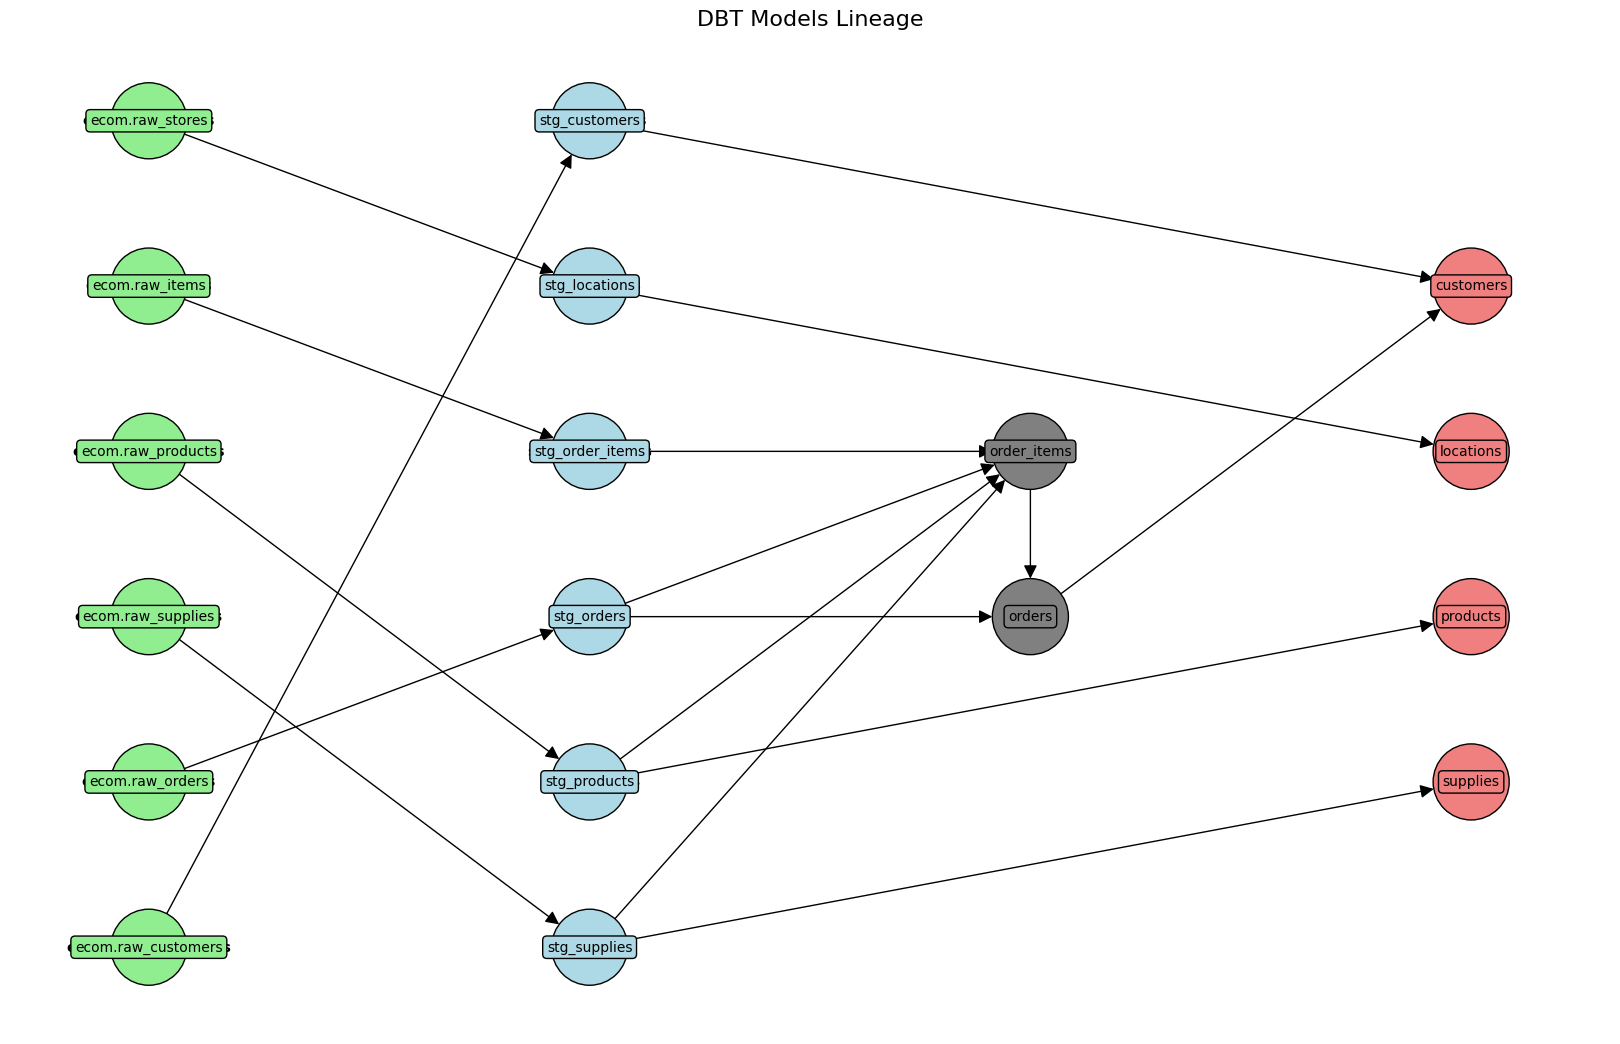

In [14]:
lineage_df = plot_dbt_lineage(dbt_repo_knowledge_df)

#### Test simple Retriever

In [15]:
from langchain.chains import RetrievalQA, LLMChain, SequentialChain
from langchain.prompts import PromptTemplate
from langchain_openai import ChatOpenAI
from langchain.agents import initialize_agent, Tool
from langchain.schema.runnable import RunnableSequence

llm = ChatOpenAI(model=DEFAULT_LLM_MODEL, temperature=0.1, openai_api_key=OPENAI_API_KEY, openai_organization = OPENAI_ORGANIZATION)
retriever = vectorstore.as_retriever(search_type="similarity", search_kwargs={"k": 5})

In [16]:
template = """
    You are a dbt expert. Based on the following context, answer the question concisely and accurately:
    {context}

    Question: {question}
"""
qa_prompt = PromptTemplate(template=template, input_variables=["context", "question"])

qa_chain = RetrievalQA.from_chain_type(
    llm=llm,
    chain_type="stuff",
    retriever=retriever,
    return_source_documents=True,
    chain_type_kwargs={"prompt": qa_prompt},
)

In [17]:
query = "Que modelos se veran fectados si cambio el nombre de customer_id en stg_customers"
result = qa_chain.invoke({"query": query})

print(result["result"])
print(result["source_documents"])

Si cambias el nombre de `customer_id` en el modelo `stg_customers`, los siguientes modelos se verán afectados:

1. **Modelo `customers`**: Este modelo utiliza `customer_id` para unirse con el resumen de pedidos (`customer_orders_summary`). Cualquier referencia a `customer_id` en este modelo deberá actualizarse para reflejar el nuevo nombre.

2. **Modelo `customer_orders_summary`**: Aunque no se menciona explícitamente en el código, si `customer_orders_summary` se basa en `customer_id` de `stg_customers`, también se verá afectado indirectamente.

Asegúrate de actualizar todas las referencias a `customer_id` en los modelos y en los archivos YML correspondientes para evitar errores.
[Document(id='8546ccf0-c0e9-4978-af26-9f2837e26d09', metadata={'knowledge_type': 'project', 'name': 'raw_orders.csv', 'path': 'jaffle-data/raw_orders.csv', 'source': None, 'parents': None, 'children': None, 'config': None, 'materialized': None, 'is_snapshot': None, 'model_category': None, 'vertical': None, 'ha

#### Agent test

In [18]:
# Retrieval Tool
retrieval_tool = Tool(
    name="Retrieve Info",
    func=lambda query: retriever.get_relevant_documents(query),
    description="Retrieve relevant context from the knowledge base.",
)

# Task Execution Prompt
task_prompt = PromptTemplate(
    template="""
        You are a dbt expert. Based on the context provided, perform the task below step-by-step:
        
        Task: {question}
        Context: {context}
    """,
    input_variables=["context", "question"],
)

# QA Chain for Task Execution
qa_chain = RetrievalQA.from_chain_type(
    llm=llm,
    chain_type="stuff",
    retriever=retriever,
    return_source_documents=True,
    chain_type_kwargs={"prompt": task_prompt},
)

# Task Execution Tool
task_tool = Tool(
    name="DBT Task Executor",
    func=lambda query: qa_chain.invoke({"query": query}),
    description="Execute dbt-related tasks like adding columns, creating models, or verifying dependencies.",
)

# Agent Configuration
tools = [retrieval_tool, task_tool]

agent = initialize_agent(
    tools=tools,
    llm=llm,
    agent="zero-shot-react-description",
    verbose=True,
)

/var/folders/hv/ckh3m6gn1sd45q2qctrqcwzh0000gn/T/ipykernel_50401/586826549.py:38: LangChainDeprecationWarning: LangChain agents will continue to be supported, but it is recommended for new use cases to be built with LangGraph. LangGraph offers a more flexible and full-featured framework for building agents, including support for tool-calling, persistence of state, and human-in-the-loop workflows. See LangGraph documentation for more details: https://langchain-ai.github.io/langgraph/. Refer here for its pre-built ReAct agent: https://langchain-ai.github.io/langgraph/how-tos/create-react-agent/
  agent = initialize_agent(


In [19]:
# Example Query
query = "Add a new column 'customer_age' to the 'stg_customers' model. The new column is available in the customer sources"

# Run the Agent
result = agent.run(query)
print("Agent Output:", result)



> Entering new AgentExecutor chain...


/var/folders/hv/ckh3m6gn1sd45q2qctrqcwzh0000gn/T/ipykernel_50401/795793740.py:5: LangChainDeprecationWarning: The method `Chain.run` was deprecated in langchain 0.1.0 and will be removed in 1.0. Use :meth:`~invoke` instead.
  result = agent.run(query)


I need to add a new column 'customer_age' to the 'stg_customers' model. This requires executing a dbt task to modify the model and include the new column from the customer sources. 

Action: DBT Task Executor  
Action Input: Add column 'customer_age' to 'stg_customers' model using customer sources.  
Observation: {'query': "Add column 'customer_age' to 'stg_customers' model using customer sources.", 'result': 'To add the `customer_age` column to the `stg_customers` model using customer sources, follow these steps:\n\n### Step 1: Identify the Source of Customer Age Data\nFirst, we need to determine where the `customer_age` data is coming from. Assuming that the `raw_customers` source contains a date of birth or age information, we can derive the age from that.\n\n### Step 2: Modify the `stg_customers` Model\nWe will modify the existing `stg_customers` model to include the `customer_age` column. This will involve calculating the age based on a date of birth column (let\'s assume it\'s na

#### Start complete chain

In [62]:
def gather_upstream(lineage_df, model_name):
    visited = set()
    frontier = [model_name]
    while frontier:
        current = frontier.pop()
        row = lineage_df[lineage_df["model_name"] == current]
        if not row.empty:
            for source in row["source"].iloc[0]:
                if source not in visited:
                    visited.add(source)
                    frontier.append(source)
            for parent in row["parent_models"].iloc[0]:
                if parent not in visited:
                    visited.add(parent)
                    frontier.append(parent)
    return sorted(visited)

def gather_downstream(lineage_df, model_name):
    visited = set()
    frontier = [model_name]
    while frontier:
        current = frontier.pop()
        row = lineage_df[lineage_df["model_name"] == current]
        if not row.empty:
            for child in row["children_models"].iloc[0]:
                if child not in visited:
                    visited.add(child)
                    frontier.append(child)
    return sorted(visited)

def get_affected_models(lineage_df, model_name):
    up = gather_upstream(lineage_df, model_name)
    down = gather_downstream(lineage_df, model_name)
    return {
        "upstream": list(up),
        "downstream": list(down),
    }

get_affected_models(lineage_df, 'order_items')

{'upstream': ['ecom.raw_items',
  'ecom.raw_orders',
  'ecom.raw_products',
  'ecom.raw_supplies',
  'stg_order_items',
  'stg_orders',
  'stg_products',
  'stg_supplies'],
 'downstream': ['customers', 'orders']}

In [92]:
dbt_repo_knowledge_df

,knowledge_type,path,name,extension,code,config,materialized,is_snapshot,has_jinja_code,model_category,vertical,yml_code,tests,has_tests,sql_ids,has_select_all_in_last_select,has_group_by,primary_key,filters,is_filtered,macros,has_macros,parent_models,is_source_model,source,children_models,is_end_model,model_description,jinja_description,description,is_seed,is_test,packages,is_macro,contextual_info
0,models,models/staging/stg_customers.sql,stg_customers.sql,.sql,WITH SOURCE AS\n (SELECT *\n FROM {{ source...,NaN,NaN,False,False,stg,customers,"{'models': [{'name': 'stg_customers', 'descrip...","{'columns': {'customer_id': ['not_null', 'uniq...",True,['customer_id'],True,False,customer_id,NaN,False,NaN,False,[],True,['ecom.raw_customers'],['customers'],False,"""Extracts customer data from the 'raw_customer...",NaN,None,None,None,None,None,Code:\n WITH SOURCE AS\n (SELECT *\n ...
1,models,models/staging/stg_locations.sql,stg_locations.sql,.sql,WITH SOURCE AS\n (SELECT *\n FROM {{ source...,NaN,NaN,False,False,stg,locations,"{'models': [{'name': 'stg_locations', 'descrip...","{'columns': {'location_id': ['not_null', 'uniq...",True,['location_id'],True,False,location_id,NaN,False,['dbt.date_trunc'],True,[],True,['ecom.raw_stores'],['locations'],False,"""Extracts a list of open store locations from ...",NaN,None,None,None,None,None,Code:\n WITH SOURCE AS\n (SELECT *\n ...
2,models,models/staging/stg_order_items.sql,stg_order_items.sql,.sql,WITH SOURCE AS\n (SELECT *\n FROM {{ source...,NaN,NaN,False,False,stg,order_items,"{'models': [{'name': 'stg_order_items', 'descr...","{'columns': {'order_item_id': ['not_null', 'un...",True,"['product_id', 'order_item_id', 'order_id']",True,False,order_item_id,NaN,False,NaN,False,[],True,['ecom.raw_items'],['order_items'],False,"""Extracts individual food and drink items from...",NaN,None,None,None,None,None,Code:\n WITH SOURCE AS\n (SELECT *\n ...
3,models,models/staging/stg_orders.sql,stg_orders.sql,.sql,WITH SOURCE AS\n (SELECT *\n FROM {{ source...,NaN,NaN,False,False,stg,orders,"{'models': [{'name': 'stg_orders', 'descriptio...","{'columns': {'order_id': ['not_null', 'unique'...",True,"['location_id', 'store_id', 'customer_id', 'or...",True,False,order_id,NaN,False,"['cents_to_dollars', 'dbt.date_trunc']",True,[],True,['ecom.raw_orders'],"['order_items', 'orders']",False,Retrieves order data from the 'ecom.raw_orders...,NaN,None,None,None,None,None,Code:\n WITH SOURCE AS\n (SELECT *\n ...
4,models,models/staging/stg_products.sql,stg_products.sql,.sql,WITH SOURCE AS\n (SELECT *\n FROM {{ source...,NaN,NaN,False,False,stg,products,"{'models': [{'name': 'stg_products', 'descript...","{'columns': {'product_id': ['not_null', 'uniqu...",True,['product_id'],True,False,product_id,NaN,False,['cents_to_dollars'],True,[],True,['ecom.raw_products'],"['order_items', 'products']",False,Retrieves product data from the 'raw_products'...,NaN,None,None,None,None,None,Code:\n WITH SOURCE AS\n (SELECT *\n ...
5,models,models/staging/stg_supplies.sql,stg_supplies.sql,.sql,WITH SOURCE AS\n (SELECT *\n FROM {{ source...,NaN,NaN,False,False,stg,supplies,"{'models': [{'name': 'stg_supplies', 'descript...","{'columns': {'supply_uuid': ['not_null', 'uniq...",True,"['product_id', 'supply_id']",True,False,supply_uuid,NaN,False,"['cents_to_dollars', 'dbt_utils.generate_surro...",True,[],True,['ecom.raw_supplies'],"['order_items', 'supplies']",False,Retrieves supply expense data from the 'raw_su...,NaN,None,None,None,None,None,Code:\n WITH SOURCE AS\n (SELECT *\n ...
6,models,models/marts/customers.sql,customers.sql,.sql,WITH customers AS\n (SELECT *\n FROM {{ ref...,NaN,NaN,False,False,other,customers,"{'models': [{'name': 'customers', 'description...","{'columns': {'customer_id': ['not_null', 'uniq...",True,"['customer_id', 'order_id']",True,True,customer_id,['customers.customer_id = customer_orders_summ...,True,NaN,False,"['stg_customers', 'orders']",False,NaN,[],True,"""Aggregates customer data from the 'stg_custom..

In [ ]:
from langchain.chains import LLMChain
from langchain.prompts import PromptTemplate

class Step:
    """Base class for a step in the processing pipeline."""
    def __init__(self, name):
        self.name = name

    def execute(self, input_data, context):
        raise NotImplementedError("Each step must implement the execute method.")

class InterpretationStep(Step):
    """Evaluate the user's request and decide the type of action needed."""
    def __init__(self, llm):
        super().__init__("Interpretation")
        self.llm = llm
        self.prompt_template = PromptTemplate(
            input_variables=["request"],
            template=("""
                <<>ROLE>>>
                You are an expert in interpreting user requests and translating them into clear and concise decisions and actions, based on your deep expertise as an Analytics Engineer, knowledge of dbt and in interpreting and translating problems into solutions.      

                <<<TASK>>>      
                Evaluate the request: {request}
                --------------------
                and based on the evaluation, determine the required action:
                1) adding a field -> return ADD_COLUMN
                2) modifying an existing model -> return MODIFY_MODEL
                3) retrieving and returning specific information. -> return RETRIVE_INFO
                
                Reflect on the request and provide a concise plan for the approach:
                - If the action involves adding a field: Identify where the field is currently available, if provided.
                - Determine how to propagate the field through the necessary models or transformations to integrate it into the target model.
                - Consider the impact on related models and dependencies.
                - If the action involves modifying an existing model: Identify the specific changes required.
                - Assess how these changes affect the structure, relationships, and downstream dependencies of the model.
                - If the action involves retrieving or returning information: Identify the models containing the relevant data.
                - Analyze how these models are related, and determine the queries or transformations needed to extract the requested information.
                      
                <<<OUPUT>>>
                Return the required action from the three proposed, and a short explanaition of the required work.
                REMEMBER: Provide no extra commentary or explanation, just the minimal information required,  
                return only useful information, no additional filler text or unnecessary explanations, get to the point.
            """)   
        )

    def execute(self, input_data, context):
        print(f"Step: {self.name} | Input: {input_data}")
        prompt = self.prompt_template.format(request=input_data)
        interpretation = self.llm.invoke(prompt)
        context["interpretation"] = interpretation
        print(f"Step: {self.name} | Output: {interpretation}")
        return interpretation

class EvaluationStep(Step):
    """Evaluates on the user's request based on evaluation."""
    def __init__(self, llm):
        super().__init__("Evaluation")
        self.llm = llm
        self.prompt_template = PromptTemplate(
            input_variables=["request", "interpretation"],
            template=("""
                <<>ROLE>>>
                You are an expert in evaluating user requests and translating them into clear and concise decisions and actions, based on your deep expertise as an Analytics Engineer, knowledge of dbt and in interpreting and translating requests into solutions.      

                <<<TASK>>>      
                Based on the interpretation of an expert dbt and problem interpreter: {interpretation}
                --------------------
                of the original request
                ORIGINAL REQUEST: {request}
                --------------------
                Include only these topics if relevant:
                - Target models or files
                - Field existence
                - Documentation needs
                - Dependencies and relationships
                - Performance/design considerations
                - Tests
                - dbt project config
                - Code or logic generation
                
                Summarize only the necessary actions, no filler. Think about all the considerations and steps required to handle this request effectively.
                Your evaluation could include the following actions:
                - Identify the target model or models: Analyze the dependency tree to locate the model where the change should occur.
                - Understand its upstream sources (seeds, sources or base models) and downstream dependencies.
                - Check for field or model existence: Determine if the required field or base model already exists.
                - If not, specify the steps to create it, including generating the necessary base table or model.
                - Documentation: Assess whether the target model and its sources are documented.
                - If documentation is missing or outdated, note whether it needs to be created or updated.
                - Unique keys and IDs: Examine the available unique keys and identifiers in the initial, intermediate, and final models.
                - Decide how these can be used to integrate the field or establish relationships between models.
                - Evaluate performance and design: Review the data pipeline from start to finish.
                - Decide where the change or addition would be most optimal in terms of performance, data modeling, and maintainability.
                - Project state and impact: Consider the current state of the dbt project and how the changes might affect the broader model chain.
                - Macros and seeds: Check if relevant macros or seed data exist that can help transform or derive the required field or model.
                - Tests: Identify existing tests for the field or model and determine whether new tests need to be added or adjusted to validate the changes.
                - dbt project configuration: Review the general configuration (e.g., variables, environments, conventions) in the dbt_project.yml file to ensure the changes align with project standards and won't disrupt the schema.
                - Code generation:  fragments of SQL logic needed, including CTEs or columns.
                - Evaluate whether an intermediate model is necessary or if the logic can be handled within the existing pipeline.
                - Documentation generation: Specify the documentation needed for any fields, models, or logic added or updated as part of this request. Only the things to add or change.
                
                <<<OUPUT>>>
                Provide a concise summary of the high-level plan based on your analysis.
                No extra checks or steps that are not on this list, select only the needed actions for the request.
                Return only useful information, no additional filler text or unnecessary explanations, get to the point.
                      
                REMEMBER: Provide no extra commentary or explanation, just the minimal information required.
            """)
        )

    def execute(self, input_data, context):
        print(f"Step: {self.name} | Input: {input_data}")
        interpretation = context.get("interpretation", "")
        prompt = self.prompt_template.format(request=input_data, interpretation=interpretation)
        evaluation = self.llm.invoke(prompt)
        context["evaluation"] = evaluation
        print(f"Step: {self.name} | Output: {evaluation}")
        return evaluation

from pydantic import BaseModel, Field
from typing import Literal
from langchain.output_parsers import PydanticOutputParser

class LineageResponse(BaseModel):
    model: str
    scope: Literal['UP', 'DOWN', 'ALL']

class LineageStep(Step):
    """Identify which models or documents should be consulted or modified using dbt lineage."""
    def __init__(self, llm):
        super().__init__("Lineage")
        self.llm = llm
        self.retriever = retriever

        self.parser = PydanticOutputParser(pydantic_object=LineageResponse)

        self.prompt_template = PromptTemplate(
            input_variables=["evaluation", "retrieved_context"],
            template=("""
                <<>ROLE>>>
                You are an expert in identifying the models and changes needed in a dbt repo given a request, based on your deep expertise as an Analytics Engineer, knowledge of dbt and in interpreting and translating requests into solutions, and using context and context information from the repository code and other models.

                <<<TASK>>>      
                Based on this evaluation: {evaluation}
                --------------------
                and the retrieved context, remember the meaning of all the context data:
                CONTEXT INFO AND METADATA MEANING:
                - knowledge_type: Specifies whether the resource is about files within the dbt project configuration, or data models used in the pipeline.
                - name: Name of the file.
                - path: Path within the repository where the file or resource is located, relative to the project root.
                - source: The original dataset, from which the model or resource pulls its data. Only for the first layer of the model.
                - parents: dbt models  that serve as input dependencies for the current model or file.
                - children: dbt models that depend on this resource as an input for their logic or data processing.
                - config: Configuration parameters defined in the file, specifying behaviors, sort keys, materialization...
                - materialized: Indicates how the data model is materialized (e.g., as a table, view, or ephemeral model) in the pipeline.
                - is_snapshot: Boolean flag that identifies whether the file represents a snapshot dbt model.
                - model_category: The logical dbt categorization of the model inside the project, such as base, staging, intermediate, marts...
                - vertical: Business domain or vertical to which the resource belongs, such as e-commerce, finance, supply...
                - has_tests: Boolean flag indicating if there are tests associated with this resource in the model .yaml file or in the tests folder.
                - has_select_all_in_last_select: Specifies if the final SQL query in the file uses a SELECT * statement. So all columns of previous CTEs will be consider as output of the model.
                - has_group_by: Boolean flag indicating if the SQL code includes a GROUP BY clause for aggregating data.
                - is_filtered: Boolean flag that specifies whether the resource applies filters to its data with WHERE, HAVING, JOIN...
                - is_source_model: The model uses the source macro to extract the data from the dbt project sources. It belongs to the first layer of all dbt models.
                - is_seed: Specifies if the resource is a seed file.
                - is_end_model: Boolean flag identifying if this is a terminal model in the data pipeline, representing the final output.
                - is_macro: Boolean flag indicating if the file defines a macro, used for reusable logic across the project. It does not count macros ref to call other models or source to connect to sources.
                - is_test: Indicates whether the file is a test sql definition used for testing purposes of other dbt models.
                - macros: Name of the macros used in the dbt model if any. It does not count macros ref to call other models or source to connect to sources.
                - packages: List of external packages or dependencies required for the resource or project functionality. Only not None in the packages.yml	row.

                      
                RETRIEVED CONTEXT: {retrieved_context}
                --------------------
                Determine:
                - The primary dbt model directly affected (e.g., where a field is added, a modification is made, or information is requested).
                - Whether upstream models (UP), downstream models (DOWN), or both (ALL) are necessary to handle this request correctly.
                
                Consider the following cases:
                1. If a new field is added, specify the model where the field will be added and indicate UP for upstream models needed to populate the field.
                2. If an existing field is modified, specify the model where the change occurs and indicate DOWN for downstream models affected by the change.
                3. If information is requested, specify the model containing the requested information and indicate UP, DOWN, or ALL based on the context of the data needed.
                4. If a field or model is removed, specify the model being affected and indicate DOWN for downstream dependencies impacted.
                      
                <<<OUPUT>>>
                Return the following json format: {{'model':model name, 'scope':UP/DOWN/ALL}}
                REMEMBER: Provide no extra commentary or explanation, just the minimal information required.
            """)
        )

    def execute(self, input_data, context):
        print(f"Step: {self.name} | Input: {input_data}")
        evaluation = context.get("evaluation", "")

        documents = self.retriever.invoke(input_data)
        retrieved_context = "\n".join([doc.page_content for doc in documents if hasattr(doc, 'page_content')])
        context["documents"] = documents
        print(f"Step: {self.name} | Retrieved Context: {retrieved_context}")

        prompt = self.prompt_template.format(evaluation=evaluation, retrieved_context=retrieved_context)

        response = self.llm.invoke(prompt)
        context["lineage_analysis"] = response.dict()
        print(f"Step: {self.name} | Output: {response}")


        # ADD DOC FILTERING

        return response

class PlanStep(Step):
    """Plan the steps needed based on evaluation and retrieved context."""
    def __init__(self, llm, retriever):
        super().__init__("Plan")
        self.llm = llm
        self.retriever = retriever
        self.prompt_template = PromptTemplate(
            input_variables=["evaluation", "retrieved_context", "lineage_analysis"],
            template=("""
                <<>ROLE>>>
                You are an expert in planning and deciding the necessary changes in the affected models of a dbt project given a request, based on your deep expertise as an Analytics Engineer, knowledge of dbt and in interpreting and translating requests into solutions, and using context and context information from the repository code and other models.      

                <<<TASK>>>      
                Based on this evaluation: {evaluation}
                --------------------
                and the retrieved context, remember the meaning of all the context data:
                CONTEXT INFO AND METADATA MEANING:
                - knowledge_type: Specifies whether the resource is about files within the dbt project configuration, or data models used in the pipeline.
                - name: Name of the file.
                - path: Path within the repository where the file or resource is located, relative to the project root.
                - source: The original dataset, from which the model or resource pulls its data. Only for the first layer of the model.
                - parents: dbt models  that serve as input dependencies for the current model or file.
                - children: dbt models that depend on this resource as an input for their logic or data processing.
                - config: Configuration parameters defined in the file, specifying behaviors, sort keys, materialization...
                - materialized: Indicates how the data model is materialized (e.g., as a table, view, or ephemeral model) in the pipeline.
                - is_snapshot: Boolean flag that identifies whether the file represents a snapshot dbt model.
                - model_category: The logical dbt categorization of the model inside the project, such as base, staging, intermediate, marts...
                - vertical: Business domain or vertical to which the resource belongs, such as e-commerce, finance, supply...
                - has_tests: Boolean flag indicating if there are tests associated with this resource in the model .yaml file or in the tests folder.
                - has_select_all_in_last_select: Specifies if the final SQL query in the file uses a SELECT * statement. So all columns of previous CTEs will be consider as output of the model.
                - has_group_by: Boolean flag indicating if the SQL code includes a GROUP BY clause for aggregating data.
                - is_filtered: Boolean flag that specifies whether the resource applies filters to its data with WHERE, HAVING, JOIN...
                - is_source_model: The model uses the source macro to extract the data from the dbt project sources. It belongs to the first layer of all dbt models.
                - is_seed: Specifies if the resource is a seed file.
                - is_end_model: Boolean flag identifying if this is a terminal model in the data pipeline, representing the final output.
                - is_macro: Boolean flag indicating if the file defines a macro, used for reusable logic across the project. It does not count macros ref to call other models or source to connect to sources.
                - is_test: Indicates whether the file is a test sql definition used for testing purposes of other dbt models.
                - macros: Name of the macros used in the dbt model if any. It does not count macros ref to call other models or source to connect to sources.
                - packages: List of external packages or dependencies required for the resource or project functionality. Only not None in the packages.yml	row.

                RETRIEVED CONTEXT: {retrieved_context}
                --------------------
                Create a detailed step-by-step plan of the changes required in the existing models or files within the repository.
                To implement the requested change accurately.
                1. Ensure that you only refer to files, models, or fields that are explicitly mentioned in the retrieved information.
                2. Do not invent new models, fields, or dependencies. 
                3. Focus on:
                  - Identifying the exact files or models that need modifications, based on the retrieved context.
                  - Specifying what changes should be made, such as adding fields, updating logic, or modifying relationships.
                  - Highlighting any dependencies between models or files and describing how these should be handled.
                  - Extract children or parent models affected.
                  - If code fragments are provided in the retrieved context, incorporate them where applicable and explain their role.
                  - If no specific code or file is mentioned in the retrieved information, state that no changes should be made to existing files.
                  - Ensure the changes align with the dbt project's standards, such as conventions in `dbt_project.yml`, and do not introduce schema-breaking modifications.
                
                4. No extra checks or steps that are not on this list.
                5. Provide precise and actionable recommendations, avoiding any assumptions beyond the retrieved information.
                      
                <<<OUPUT>>>
                Return only useful information, no additional filler text or unnecessary explanations, get to the point.
                REMEMBER: Provide no extra commentary or explanation, just the minimal information required.
            """)
        )

    def execute(self, input_data, context):
        print(f"Step: {self.name} | Input: {input_data}")
        evaluation = context.get("evaluation", "")
        lineage_analysis = context.get("lineage_analysis", "")

        documents = self.retriever.invoke(input_data)
        retrieved_context = "\n".join([doc.page_content for doc in documents if hasattr(doc, 'page_content')])
        context["documents"] = documents
        print(f"Step: {self.name} | Retrieved Context: {retrieved_context}")

        prompt = self.prompt_template.format(evaluation=evaluation, retrieved_context=retrieved_context)

        plan = self.llm.invoke(prompt)
        context["plan"] = plan
        print(f"Step: {self.name} | Output: {plan}")
        return plan

class ChatPipeline:
    """Manages the pipeline of steps."""
    def __init__(self, steps):
        self.steps = steps

    def execute(self, input_data):
        context = {}
        for step in self.steps:
            print(f"\nExecuting step: {step.name}")
            result = step.execute(input_data, context)
            print(f"Finished step: {step.name} | Result: {result}\n")
        return context

def main(user_input, llm, retriever):
    # Define the steps
    steps = [
        InterpretationStep(llm),
        EvaluationStep(llm),
        LineageStep(llm),
        PlanStep(llm, retriever),
    ]

    # Create the pipeline
    pipeline = ChatPipeline(steps)

    context = pipeline.execute(user_input)
    print("Context at the end of pipeline:", context)

    return context

In [84]:
user_input = "si cambio algo en el modelo de salida orders, cuales son todos sus parent models que tendria que consultar"
llm_results = main(user_input, llm, retriever)


Executing step: Interpretation
Step: Interpretation | Input: si cambio algo en el modelo de salida orders, cuales son todos sus parent models que tendria que consultar
Step: Interpretation | Output: content='RETRIVE_INFO: You need to identify all parent models related to the output model "orders" to understand the dependencies and relationships that may be affected by any changes made.' additional_kwargs={'refusal': None} response_metadata={'token_usage': {'completion_tokens': 36, 'prompt_tokens': 359, 'total_tokens': 395, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_0aa8d3e20b', 'finish_reason': 'stop', 'logprobs': None} id='run-7c34e00d-6cb3-46b3-8079-92a2564decf4-0' usage_metadata={'input_tokens': 359, 'output_tokens': 36, 'total_tokens': 395, 'input_token_de

/var/folders/hv/ckh3m6gn1sd45q2qctrqcwzh0000gn/T/ipykernel_50401/2570740613.py:180: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.10/migration/
  context["lineage_analysis"] = response.dict()


Step: Lineage | Output: content="```json\n{'model': 'stg_orders', 'scope': 'ALL'}\n```" additional_kwargs={'refusal': None} response_metadata={'token_usage': {'completion_tokens': 19, 'prompt_tokens': 2272, 'total_tokens': 2291, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_d02d531b47', 'finish_reason': 'stop', 'logprobs': None} id='run-f5b62307-4e61-4d9a-b1f8-83bf52ec90d7-0' usage_metadata={'input_tokens': 2272, 'output_tokens': 19, 'total_tokens': 2291, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}}
Finished step: Lineage | Result: content="```json\n{'model': 'stg_orders', 'scope': 'ALL'}\n```" additional_kwargs={'refusal': None} response_metadata={'token_usage': {'completion_tokens': 19, 'prompt_token

In [85]:
Markdown(llm_results['plan'].content)

1. **Identify Target Model**: The target model is `stg_orders`.

2. **Understand Upstream Sources**: The upstream source for `stg_orders` is `ecom.raw_orders`.

3. **Check Field Existence**: Ensure the following fields exist in the `raw_orders` source:
   - `id`
   - `customer`
   - `ordered_at`
   - `store_id`
   - `subtotal`
   - `tax_paid`
   - `order_total`

4. **Documentation Needs**: Update or create documentation for the `stg_orders` model, ensuring it reflects the current transformations and logic applied.

5. **Evaluate Performance and Design**: Review the SQL logic in the `stg_orders` model to ensure optimal performance. The current logic is:
   ```sql
   WITH SOURCE AS
     (SELECT *
      FROM {{ source('ecom', 'raw_orders') }}), 
   renamed AS
     (SELECT 
       id AS order_id,
       store_id AS location_id,
       customer AS customer_id,
       subtotal AS subtotal_cents,
       tax_paid AS tax_paid_cents,
       order_total AS order_total_cents,
       {{ cents_to_dollars('subtotal') }} AS subtotal,
       {{ cents_to_dollars('tax_paid') }} AS tax_paid,
       {{ cents_to_dollars('order_total') }} AS order_total,
       {{ dbt.date_trunc('day', 'ordered_at') }} AS ordered_at
      FROM SOURCE)
   SELECT *
   FROM renamed
   ```

6. **Project State and Impact**: Assess the current state of the dbt project to ensure that any changes do not disrupt existing models or dependencies.

7. **Tests**: The existing tests for `stg_orders` include:
   - `order_id` should be `not_null` and `unique`.
   - Add a test to ensure `order_total - tax_paid = subtotal` is valid.

8. **dbt Project Configuration**: Ensure that any changes made align with the configurations in `dbt_project.yml` to avoid schema disruptions.

9. **Documentation Generation**: Specify updates to the documentation for the `stg_orders` model, including descriptions for the fields and any new tests added.